In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.integrate import solve_ivp,trapezoid
import math
import mpmath as mp
import os
from scipy.interpolate import interp1d


## Physical parameters

In [2]:
## All air-mucus parameters correspond to Table 2 in
## Dietze and Ruyer-Quil (J. Fluid Mech., 762, 2015, 68). 
ep = 1           ## aspect ratio
nG = 300         ## spatial grid points
d0 = 0.8         ## average interface position
L = 6            ## Domain length
R = 1.5e-3       ## Tube radius
gamma_am = 0.031 ## air-mucus surface tension
mu_a  = 1.8e-5   ## air viscosity
mu_m  = 3.1e-3   ## mucus viscosity
rho_a = 1.2      ## air density 
rho_m = 1098.3   ## mucus density 
Lamnda_R = L  

In [3]:
## calculating non-dimensional parameters
alpha_star = 2*np.pi*d0/(Lamnda_R)
lambda_star = 1/alpha_star
tau = (6*mu_m*R*d0/gamma_am)/(alpha_star**4*(1/alpha_star**2-1)*(1/d0-1)**2*(1/d0**2-1))
## tau correspond to eq. 3.1 in Dietze et al. 2015
u_char = gamma_am/mu_m
PI_rho = rho_a/rho_m
PI_mu = mu_a/mu_m
Re_m = rho_m*R**2/(mu_m*tau)
Re_a = Re_m*PI_rho/PI_mu
La_m = rho_m*gamma_am*R/mu_m**2
Ca = gamma_am/(mu_m*u_char)

def dUcdt(t):
    return np.zeros(nG)
def Uc(t):
    return np.zeros(nG)

frequency = 1
omega = 2*np.pi*frequency*R*mu_m/gamma_am
A = 0
G = A*R**2/(mu_a*u_char)
def body_force(t):
    return G*(np.sin(omega*t))

## Setting up the numerical solver for the WRIBL equations

In [4]:
## grid
n = nG
h = (L-0) / n
lesz = np.arange(0,L,h)

In [5]:
## Derivative matrices

## D1: central difference
D1c =np.zeros((n,n))
## boundary nodes: periodic
D1c[0,0]= 0
D1c[0,1]=1
D1c[0,-1]=-1
D1c[-1,0]= 1
D1c[-1,-2]=-1
D1c[-1,-1]=0
## internal nodes
for i in range(1, n-1):
    D1c[i,i-1] = -1
    D1c[i,i] = 0
    D1c[i,i+1]=1 
D1c = 1/(2*h)*D1c

## D2: central difference
D2c =np.zeros((n, n))
## boundary nodes: periodic
D2c[0, 0] = -2
D2c[0, n-1] = 1
D2c[0, 1] = 1
D2c[n-1, n-1] = -2
D2c[n-1, n-2] = 1
D2c[n-1, 0] = 1
## internal nodes
for i in range(1, n-1):
    D2c[i, i-1] = 1
    D2c[i, i] = -2
    D2c[i, i+1] = 1 
D2c = 1/(h**2)*D2c

## D1: forward difference
D1f =np.zeros((n,n))
## boundary nodes: periodic
D1f[0,0]= -1
D1f[0,1]=1
D1f[-1,0]= 1
D1f[-1,-1]=-1
## internal nodes
for i in range(1, n-1):
    D1f[i,i] = -1
    D1f[i,i+1]=1 
D1f = 1/(h)*D1f
## av matrix:
M1av = np.zeros((n,n))
## boundary nodes: periodic
M1av[0,0]= 1
M1av[0,1]=1
M1av[-1,0]= 1
M1av[-1,-1]=1
## internal nodes
for i in range(1, n-1):
    M1av[i,i] = 1
    M1av[i,i+1]=1 
M1av = 1/(2)*M1av

In [6]:
## grid for interpolation function
d_i = np.linspace(0.1,0.999,10000)

1. All coefficients with tilde in the paper are presented here with a subscript 'p', e.g., $\tilde {S_{aa}}$ as Saap
2. Coefficients associated with cilia (subscript 'c') in the paper are presented denoted with 'w' here, e.g., $F_{acc}$ as Faww

In [7]:
## defining symbolic variables and functions
r,t,z = sp.symbols('r t z ',real = True)
d = sp.Function('d',real=True)(z,t)
Q_a = sp.Function('Q_a',real=True)(z,t)
Q_m = sp.Function('Q_m',real=True)(z,t)
Q_t = sp.Function('Q_t',real=True)(t)
U_w= sp.Function('U_w',real=True)(z,t)
kappa= sp.Function('kappa',real=True)(z,t)
dpdz_d = sp.Function('dpdz_d',real=True)(z,t)
Saa_s = sp.Function('Saa_s',real=True)(d)
Sam_s = sp.Function('Sam_s',real=True)(d)
Saw_s = sp.Function('Saw_s',real=True)(d)
Saap_s = sp.Function('Saap_s',real=True)(d) 
Samp_s = sp.Function('Samp_s',real=True)(d)
Sawp_s = sp.Function('Sawp_s',real=True)(d)
Sma_s = sp.Function('Sma_s',real=True)(d)
Smm_s = sp.Function('Smm_s',real=True)(d)
Smw_s = sp.Function('Smw_s',real=True)(d)
Smap_s = sp.Function('Smap_s',real=True)(d)
Smmp_s = sp.Function('Smmp_s',real=True)(d)
Smwp_s = sp.Function('Smwp_s',real=True)(d)

In [8]:
## Reading WRIBL coefficients from the text files
Aa1= open("./Two_way_coefficients/Saa.txt","r")
Aa1s = Aa1.read()
def Saa(d):
    return eval(Aa1s)
Saa_in = Saa(d_i)
interp_func_Saa = interp1d(d_i,Saa_in,kind='cubic')
def Saa_i(d):
    return interp_func_Saa(d)


Aap1= open("./Two_way_coefficients/Saap.txt","r")
Aap1s = Aap1.read()
def Saa_p(d):
    return eval(Aap1s)
Saa_p_in = Saa_p(d_i)
interp_func_Saa_p = interp1d(d_i,Saa_p_in,kind='cubic')
def Saa_pi(d):
    return interp_func_Saa_p(d)


Am1= open("./Two_way_coefficients/Sma.txt","r")
Am1s = Am1.read()
def Sma(d):
    return eval(Am1s)
Sma_in =  Sma(d_i)
interp_func_Sma = interp1d(d_i,Sma_in,kind='cubic')
def Sma_i(d):
    return interp_func_Sma(d)


Amp1= open("./Two_way_coefficients/Smap.txt","r")
Amp1s = Amp1.read()
def Sma_p(d):
    return eval(Amp1s)
Sma_p_in = Sma_p(d_i)
interp_func_Sma_p = interp1d(d_i,Sma_p_in,kind='cubic')
def Sma_pi(d):
    return interp_func_Sma_p(d)


Aa2= open("./Two_way_coefficients/Sam.txt","r")
Aa2s = Aa2.read()
def Sam(d):
    return eval(Aa2s)
Sam_in = Sam(d_i)
interp_func_Sam = interp1d(d_i,Sam_in,kind='cubic')
def Sam_i(d):
    return interp_func_Sam(d)


Aap2= open("./Two_way_coefficients/Samp.txt","r")
Aap2s = Aap2.read()
def Sam_p(d):
    return eval(Aap2s)
Sam_p_in = Sam_p(d_i)
interp_func_Sam_p = interp1d(d_i,Sam_p_in,kind='cubic')
def Sam_pi(d):
    return interp_func_Sam_p(d)


Am2= open("./Two_way_coefficients/Smm.txt","r")
Am2s = Am2.read()
def Smm(d):
    return eval(Am2s)
Smm_in = Smm(d_i)
interp_func_Smm = interp1d(d_i,Smm_in,kind='cubic')
def Smm_i(d):
    return interp_func_Smm(d)


Amp2= open("./Two_way_coefficients/Smmp.txt","r")
Amp2s = Amp2.read()
def Smm_p(d):
    return eval(Amp2s)
Smm_p_in = Smm_p(d_i)
interp_func_Smm_p = interp1d(d_i,Smm_p_in,kind='cubic')
def Smm_pi(d):
    return interp_func_Smm_p(d)


Aa3= open("./Two_way_coefficients/Saw.txt","r")
Aa3s = Aa3.read()
def Saw(d):
    return eval(Aa3s)
Saw_in = Saw(d_i)
interp_func_Saw = interp1d(d_i,Saw_in,kind='cubic')
def Saw_i(d):
    return interp_func_Saw(d)


Aap3= open("./Two_way_coefficients/Sawp.txt","r")
Aap3s = Aap3.read()
def Saw_p(d):
    return eval(Aap3s)
Saw_p_in = Saw_p(d_i)
interp_func_Saw_p = interp1d(d_i,Saw_p_in,kind='cubic')
def Saw_pi(d):
    return interp_func_Saw_p(d)


Am3= open("./Two_way_coefficients/Smw.txt","r")
Am3s = Am3.read()
def Smw(d):
    return eval(Am3s)
Smw_in = Smw(d_i)
interp_func_Smw = interp1d(d_i,Smw_in,kind='cubic')
def Smw_i(d):
    return interp_func_Smw(d)

Amp3= open("./Two_way_coefficients/Smwp.txt","r")
Amp3s = Amp3.read()
def Smw_p(d):
    return eval(Amp3s)
Smw_p_in = Smw_p(d_i)
interp_func_Smw_p = interp1d(d_i,Smw_p_in,kind='cubic')
def Smw_pi(d):
    return interp_func_Smw_p(d)

Aa4= open("./Two_way_coefficients/Faaa.txt","r")
Aa4s = Aa4.read()
def Faaa(d):
    return eval(Aa4s)
Faaa_in = Faaa(d_i)
interp_func_Faaa = interp1d(d_i,Faaa_in,kind='cubic')
def Faaa_i(d):
    return interp_func_Faaa(d)

Aap4= open("./Two_way_coefficients/Faaap.txt","r")
Aap4s = Aap4.read()
def Faaa_p(d):
    return eval(Aap4s)
Faaap_in = Faaa_p(d_i)
interp_func_Faaap = interp1d(d_i,Faaap_in,kind='cubic')
def Faaa_pi(d):
    return interp_func_Faaap(d)

Am4= open("./Two_way_coefficients/Fmaa.txt","r")
Am4s = Am4.read()
def Fmaa(d):
    return eval(Am4s)
Fmaa_in = Fmaa(d_i)
interp_func_Fmaa = interp1d(d_i,Fmaa_in,kind='cubic')
def Fmaa_i(d):
    return interp_func_Fmaa(d)

Amp4= open("./Two_way_coefficients/Fmaap.txt","r")
Amp4s = Amp4.read()
def Fmaa_p(d):
    return eval(Amp4s)
Fmaap_in = Fmaa_p(d_i)
interp_func_Fmaap = interp1d(d_i,Fmaap_in,kind='cubic')
def Fmaa_pi(d):
    return interp_func_Fmaap(d)

Aa5= open("./Two_way_coefficients/Faam.txt","r")
Aa5s = Aa5.read()
def Faam(d):
    return eval(Aa5s)
Faam_in = Faam(d_i)
interp_func_Faam = interp1d(d_i,Faam_in,kind='cubic')
def Faam_i(d):
    return interp_func_Faam(d)

Aap5= open("./Two_way_coefficients/Faamp.txt","r")
Aap5s = Aap5.read()
def Faam_p(d):
    return eval(Aap5s)
Faamp_in = Faam_p(d_i)
interp_func_Faamp = interp1d(d_i,Faamp_in,kind='cubic')
def Faam_pi(d):
    return interp_func_Faamp(d)

Am5= open("./Two_way_coefficients/Fmam.txt","r")
Am5s = Am5.read()
def Fmam(d):
    return eval(Am5s)
Fmam_in = Fmam(d_i)
interp_func_Fmam = interp1d(d_i,Fmam_in,kind='cubic')
def Fmam_i(d):
    return interp_func_Fmam(d)

Amp5= open("./Two_way_coefficients/Fmamp.txt","r")
Amp5s = Amp5.read()
def Fmam_p(d):
    return eval(Amp5s)
Fmamp_in = Fmam_p(d_i)
interp_func_Fmamp = interp1d(d_i,Fmamp_in,kind='cubic')
def Fmam_pi(d):
    return interp_func_Fmamp(d)

Aa6= open("./Two_way_coefficients/Fama.txt","r")
Aa6s = Aa6.read()
def Fama(d):
    return eval(Aa6s)

Fama_in = Fama(d_i)
interp_func_Fama = interp1d(d_i,Fama_in,kind='cubic')
def Fama_i(d):
    return interp_func_Fama(d)

Aap6= open("./Two_way_coefficients/Famap.txt","r")
Aap6s = Aap6.read()
def Fama_p(d):
    return eval(Aap6s)

Famap_in = Fama_p(d_i)
interp_func_Famap = interp1d(d_i,Famap_in,kind='cubic')
def Fama_pi(d):
    return interp_func_Famap(d)

Am6= open("./Two_way_coefficients/Fmma.txt","r")
Am6s = Am6.read()
def Fmma(d):
    return eval(Am6s)
Fmma_in = Fmma(d_i)
interp_func_Fmma = interp1d(d_i,Fmma_in,kind='cubic')
def Fmma_i(d):
    return interp_func_Fmma(d)

Amp6= open("./Two_way_coefficients/Fmmap.txt","r")
Amp6s = Amp6.read()
def Fmma_p(d):
    return eval(Amp6s)
Fmmap_in = Fmma_p(d_i)
interp_func_Fmmap = interp1d(d_i,Fmmap_in,kind='cubic')
def Fmma_pi(d):
    return interp_func_Fmmap(d)

Aa7= open("./Two_way_coefficients/Famm.txt","r")
Aa7s = Aa7.read()
def Famm(d):
    return eval(Aa7s)
Famm_in = Famm(d_i)
interp_func_Famm = interp1d(d_i,Famm_in,kind='cubic')
def Famm_i(d):
    return interp_func_Famm(d)

Aap7= open("./Two_way_coefficients/Fammp.txt","r")
Aap7s = Aap7.read()
def Famm_p(d):
    return eval(Aap7s)
Fammp_in = Famm_p(d_i)
interp_func_Fammp = interp1d(d_i,Fammp_in,kind='cubic')
def Famm_pi(d):
    return interp_func_Fammp(d)

Am7= open("./Two_way_coefficients/Fmmm.txt","r")
Am7s = Am7.read()
def Fmmm(d):
    return eval(Am7s)
Fmmm_in = Fmmm(d_i)
interp_func_Fmmm = interp1d(d_i,Fmmm_in,kind='cubic')
def Fmmm_i(d):
    return interp_func_Fmmm(d)

Amp7= open("./Two_way_coefficients/Fmmmp.txt","r")
Amp7s = Amp7.read()
def Fmmm_p(d):
    return eval(Amp7s)
Fmmmp_in = Fmmm_p(d_i)
interp_func_Fmmmp = interp1d(d_i,Fmmmp_in,kind='cubic')
def Fmmm_pi(d):
    return interp_func_Fmmmp(d)

Aa8= open("./Two_way_coefficients/Faaw.txt","r")
Aa8s = Aa8.read()
def Faaw(d):
    return eval(Aa8s)
Faaw_in = Faaw(d_i)
interp_func_Faaw = interp1d(d_i,Faaw_in,kind='cubic')
def Faaw_i(d):
    return interp_func_Faaw(d)

Aap8= open("./Two_way_coefficients/Faawp.txt","r")
Aap8s = Aap8.read()
def Faaw_p(d):
    return eval(Aap8s)
Faawp_in = Faaw_p(d_i)
interp_func_Faawp = interp1d(d_i,Faawp_in,kind='cubic')
def Faaw_pi(d):
    return interp_func_Faawp(d)

Am8= open("./Two_way_coefficients/Fmaw.txt","r")
Am8s = Am8.read()
def Fmaw(d):
    return eval(Am8s)
Fmaw_in = Fmaw(d_i)
interp_func_Fmaw = interp1d(d_i,Fmaw_in,kind='cubic')
def Fmaw_i(d):
    return interp_func_Fmaw(d)

Amp8= open("./Two_way_coefficients/Fmawp.txt","r")
Amp8s = Amp8.read()
def Fmaw_p(d):
    return eval(Amp8s)
Fmawp_in = Fmaw_p(d_i)
interp_func_Fmawp = interp1d(d_i,Fmawp_in,kind='cubic')
def Fmaw_pi(d):
    return interp_func_Fmawp(d)

Aa9= open("./Two_way_coefficients/Famw.txt","r")
Aa9s = Aa9.read()
def Famw(d):
    return eval(Aa9s)
Famw_in = Famw(d_i)
interp_func_Famw = interp1d(d_i,Famw_in,kind='cubic')
def Famw_i(d):
    return interp_func_Famw(d)

Aap9= open("./Two_way_coefficients/Famwp.txt","r")
Aap9s = Aap9.read()
def Famw_p(d):
    return eval(Aap9s)
Famwp_in = Famw_p(d_i)
interp_func_Famwp = interp1d(d_i,Famwp_in,kind='cubic')
def Famw_pi(d):
    return interp_func_Famwp(d)

Am9= open("./Two_way_coefficients/Fmmw.txt","r")
Am9s = Am9.read()
def Fmmw(d):
    return eval(Am9s)
Fmmw_in = Fmmw(d_i)
interp_func_Fmmw = interp1d(d_i,Fmmw_in,kind='cubic')
def Fmmw_i(d):
    return interp_func_Fmmw(d)

Amp9= open("./Two_way_coefficients/Fmmwp.txt","r")
Amp9s = Amp9.read()
def Fmmw_p(d):
    return eval(Amp9s)
Fmmwp_in = Fmmw_p(d_i)
interp_func_Fmmwp = interp1d(d_i,Fmmwp_in,kind='cubic')
def Fmmw_pi(d):
    return interp_func_Fmmwp(d)

Aa10= open("./Two_way_coefficients/Faww.txt","r")
Aa10s = Aa10.read()
def Faww(d):
    return eval(Aa10s)
Faww_in = Faww(d_i)
interp_func_Faww = interp1d(d_i,Faww_in,kind='cubic')
def Faww_i(d):
    return interp_func_Faww(d)

Aap10= open("./Two_way_coefficients/Fawwp.txt","r")
Aap10s = Aap10.read()
def Faww_p(d):
    return eval(Aap10s)
Fawwp_in = Faww_p(d_i)
interp_func_Fawwp = interp1d(d_i,Fawwp_in,kind='cubic')
def Faww_pi(d):
    return interp_func_Fawwp(d)

Am10= open("./Two_way_coefficients/Fmww.txt","r")
Am10s = Am10.read()
def Fmww(d):
    return eval(Am10s)
Fmww_in = Fmww(d_i)
interp_func_Fmww = interp1d(d_i,Fmww_in,kind='cubic')
def Fmww_i(d):
    return interp_func_Fmww(d)

Amp10= open("./Two_way_coefficients/Fmwwp.txt","r")
Amp10s = Amp10.read()
def Fmww_p(d):
    return eval(Amp10s)
Fmwwp_in = Fmww_p(d_i)
interp_func_Fmwwp = interp1d(d_i,Fmwwp_in,kind='cubic')
def Fmww_pi(d):
    return interp_func_Fmwwp(d)

Aa11= open("./Two_way_coefficients/Fawm.txt","r")
Aa11s = Aa11.read()
def Fawm(d):
    return eval(Aa11s)
Fawm_in = Fawm(d_i)
interp_func_Fawm = interp1d(d_i,Fawm_in,kind='cubic')
def Fawm_i(d):
    return interp_func_Fawm(d)

Aap11= open("./Two_way_coefficients/Fawmp.txt","r")
Aap11s = Aap11.read()
def Fawm_p(d):
    return eval(Aap11s)
Fawmp_in = Fawm_p(d_i)
interp_func_Fawmp = interp1d(d_i,Fawmp_in,kind='cubic')
def Fawm_pi(d):
    return interp_func_Fawmp(d)

Am11= open("./Two_way_coefficients/Fmwm.txt","r")
Am11s = Am11.read()
def Fmwm(d):
    return eval(Am11s)
Fmwm_in = Fmwm(d_i)
interp_func_Fmwm = interp1d(d_i,Fmwm_in,kind='cubic')
def Fmwm_i(d):
    return interp_func_Fmwm(d)

Amp11= open("./Two_way_coefficients/Fmwmp.txt","r")
Amp11s = Amp11.read()
def Fmwm_p(d):
    return eval(Amp11s)
Fmwmp_in = Fmwm_p(d_i)
interp_func_Fmwmp = interp1d(d_i,Fmwmp_in,kind='cubic')
def Fmwm_pi(d):
    return interp_func_Fmwmp(d)

Aa12= open("./Two_way_coefficients/Fawa.txt","r")
Aa12s = Aa12.read()
def Fawa(d):
    return eval(Aa12s)
Fawa_in = Fawa(d_i)
interp_func_Fawa = interp1d(d_i,Fawa_in,kind='cubic')
def Fawa_i(d):
    return interp_func_Fawa(d)

Aap12= open("./Two_way_coefficients/Fawap.txt","r")
Aap12s = Aap12.read()
def Fawa_p(d):
    return eval(Aap12s)
Fawap_in = Fawa_p(d_i)
interp_func_Fawap = interp1d(d_i,Fawap_in,kind='cubic')
def Fawa_pi(d):
    return interp_func_Fawap(d)

Am12= open("./Two_way_coefficients/Fmwa.txt","r")
Am12s = Am12.read()
def Fmwa(d):
    return eval(Am12s)
Fmwa_in = Fmwa(d_i)
interp_func_Fmwa = interp1d(d_i,Fmwa_in,kind='cubic')
def Fmwa_i(d):
    return interp_func_Fmwa(d)

Amp12= open("./Two_way_coefficients/Fmwap.txt","r")
Amp12s = Amp12.read()
def Fmwa_p(d):
    return eval(Amp12s)
Fmwap_in = Fmwa_p(d_i)
interp_func_Fmwap = interp1d(d_i,Fmwap_in,kind='cubic')
def Fmwa_pi(d):
    return interp_func_Fmwap(d)

Aa13= open("./Two_way_coefficients/Gaaa.txt","r")
Aa13s = Aa13.read()
def Gaaa(d):
    return eval(Aa13s)
Gaaa_in = Gaaa(d_i)
interp_func_Gaaa = interp1d(d_i,Gaaa_in,kind='cubic')
def Gaaa_i(d):
    return interp_func_Gaaa(d)

Aap13= open("./Two_way_coefficients/Gaaap.txt","r")
Aap13s = Aap13.read()
def Gaaa_p(d):
    return eval(Aap13s)
Gaaap_in = Gaaa_p(d_i)
interp_func_Gaaap = interp1d(d_i,Gaaap_in,kind='cubic')
def Gaaa_pi(d):
    return interp_func_Gaaap(d)

Am13= open("./Two_way_coefficients/Gmaa.txt","r")
Am13s = Am13.read()
def Gmaa(d):
    return eval(Am13s)
Gmaa_in = Gmaa(d_i)
interp_func_Gmaa = interp1d(d_i,Gmaa_in,kind='cubic')
def Gmaa_i(d):
    return interp_func_Gmaa(d)

Amp13= open("./Two_way_coefficients/Gmaap.txt","r")
Amp13s = Amp13.read()
def Gmaa_p(d):
    return eval(Amp13s)
Gmaap_in = Gmaa_p(d_i)
interp_func_Gmaap = interp1d(d_i,Gmaap_in,kind='cubic')
def Gmaa_pi(d):
    return interp_func_Gmaap(d)

Aa14= open("./Two_way_coefficients/Gamm.txt","r")
Aa14s = Aa14.read()
def Gamm(d):
    return eval(Aa14s)

Gamm_in = Gamm(d_i)
interp_func_Gamm = interp1d(d_i,Gamm_in,kind='cubic')
def Gamm_i(d):
    return interp_func_Gamm(d)

Aap14= open("./Two_way_coefficients/Gammp.txt","r")
Aap14s = Aap14.read()
def Gamm_p(d):
    return eval(Aap14s)

Gammp_in = Gamm_p(d_i)
interp_func_Gammp = interp1d(d_i,Gammp_in,kind='cubic')
def Gamm_pi(d):
    return interp_func_Gammp(d)

Am14= open("./Two_way_coefficients/Gmmm.txt","r")
Am14s = Am14.read()
def Gmmm(d):
    return eval(Am14s)

Gmmm_in = Gmmm(d_i)
interp_func_Gmmm = interp1d(d_i,Gmmm_in,kind='cubic')
def Gmmm_i(d):
    return interp_func_Gmmm(d)

Amp14= open("./Two_way_coefficients/Gmmmp.txt","r")
Amp14s = Amp14.read()
def Gmmm_p(d):
    return eval(Amp14s)

Gmmmp_in = Gmmm_p(d_i)
interp_func_Gmmmp = interp1d(d_i,Gmmmp_in,kind='cubic')
def Gmmm_pi(d):
    return interp_func_Gmmmp(d)

Aa15= open("./Two_way_coefficients/Gaww.txt","r")
Aa15s = Aa15.read()
def Gaww(d):
    return eval(Aa15s)
Gaww_in = Gaww(d_i)
interp_func_Gaww = interp1d(d_i,Gaww_in,kind='cubic')
def Gaww_i(d):
    return interp_func_Gaww(d)

Am15= open("./Two_way_coefficients/Gmww.txt","r")
Am15s = Am15.read()
def Gmww(d):
    return eval(Am15s)
Gmww_in = Gmww(d_i)
interp_func_Gmww = interp1d(d_i,Gmww_in,kind='cubic')
def Gmww_i(d):
    return interp_func_Gmww(d)

Aap15= open("./Two_way_coefficients/Gawwp.txt","r")
Aap15s = Aap15.read()
def Gaww_p(d):
    return eval(Aap15s)
Gawwp_in = Gaww_p(d_i)
interp_func_Gawwp = interp1d(d_i,Gawwp_in,kind='cubic')
def Gaww_pi(d):
    return interp_func_Gawwp(d)

Amp15= open("./Two_way_coefficients/Gmwwp.txt","r")
Amp15s = Amp15.read()
def Gmww_p(d):
    return eval(Amp15s)
Gmwwp_in = Gmww_p(d_i)
interp_func_Gmwwp = interp1d(d_i,Gmwwp_in,kind='cubic')
def Gmww_pi(d):
    return interp_func_Gmwwp(d)

Aa16= open("./Two_way_coefficients/Gaam.txt","r")
Aa16s = Aa16.read()
def Gaam(d):
    return eval(Aa16s)

Gaam_in = Gaam(d_i)
interp_func_Gaam = interp1d(d_i,Gaam_in,kind='cubic')
def Gaam_i(d):
    return interp_func_Gaam(d)

Aap16= open("./Two_way_coefficients/Gaamp.txt","r")
Aap16s = Aap16.read()
def Gaam_p(d):
    return eval(Aap16s)

Gaamp_in = Gaam_p(d_i)
interp_func_Gaamp = interp1d(d_i,Gaamp_in,kind='cubic')
def Gaam_pi(d):
    return interp_func_Gaamp(d)

Am16= open("./Two_way_coefficients/Gmam.txt","r")
Am16s = Am16.read()
def Gmam(d):
    return eval(Am16s)
Gmam_in = Gmam(d_i)
interp_func_Gmam = interp1d(d_i,Gmam_in,kind='cubic')
def Gmam_i(d):
    return interp_func_Gmam(d)

Amp16= open("./Two_way_coefficients/Gmamp.txt","r")
Amp16s = Amp16.read()
def Gmam_p(d):
    return eval(Amp16s)
Gmamp_in = Gmam_p(d_i)
interp_func_Gmamp = interp1d(d_i,Gmamp_in,kind='cubic')
def Gmam_pi(d):
    return interp_func_Gmamp(d)

Aa17= open("./Two_way_coefficients/Gawm.txt","r")
Aa17s = Aa17.read()
def Gawm(d):
    return eval(Aa17s)
Gawm_in = Gawm(d_i)
interp_func_Gawm = interp1d(d_i,Gawm_in,kind='cubic')
def Gawm_i(d):
    return interp_func_Gawm(d)

Aap17= open("./Two_way_coefficients/Gawmp.txt","r")
Aap17s = Aap17.read()
def Gawm_p(d):
    return eval(Aap17s)
Gawmp_in = Gawm_p(d_i)
interp_func_Gawmp = interp1d(d_i,Gawmp_in,kind='cubic')
def Gawm_pi(d):
    return interp_func_Gawmp(d)
 
Am17= open("./Two_way_coefficients/Gmwm.txt","r")
Am17s = Am17.read()
def Gmwm(d):
    return eval(Am17s)
Gmwm_in = Gmwm(d_i)
interp_func_Gmwm = interp1d(d_i,Gmwm_in,kind='cubic')
def Gmwm_i(d):
    return interp_func_Gmwm(d)

Amp17= open("./Two_way_coefficients/Gmwmp.txt","r")
Amp17s = Amp17.read()
def Gmwm_p(d):
    return eval(Amp17s)
Gmwmp_in = Gmwm_p(d_i)
interp_func_Gmwmp = interp1d(d_i,Gmwmp_in,kind='cubic')
def Gmwm_pi(d):
    return interp_func_Gmwmp(d)

Aa18= open("./Two_way_coefficients/Gawa.txt","r")
Aa18s = Aa18.read()
def Gawa(d):
    return eval(Aa18s)
Gawa_in = Gawa(d_i)
interp_func_Gawa = interp1d(d_i,Gawa_in,kind='cubic')
def Gawa_i(d):
    return interp_func_Gawa(d)

Aap18= open("./Two_way_coefficients/Gawap.txt","r")
Aap18s = Aap18.read()
def Gawa_p(d):
    return eval(Aap18s)
Gawap_in = Gawa_p(d_i)
interp_func_Gawap = interp1d(d_i,Gawap_in,kind='cubic')
def Gawa_pi(d):
    return interp_func_Gawap(d)

Am18= open("./Two_way_coefficients/Gmwa.txt","r")
Am18s = Am18.read()
def Gmwa(d):
    return eval(Am18s)
Gmwa_in = Gmwa(d_i)
interp_func_Gmwa = interp1d(d_i,Gmwa_in,kind='cubic')
def Gmwa_i(d):
    return interp_func_Gmwa(d)

Amp18= open("./Two_way_coefficients/Gmwap.txt","r")
Amp18s = Amp18.read()
def Gmwa_p(d):
    return eval(Amp18s)
Gmwap_in = Gmwa_p(d_i)
interp_func_Gmwap = interp1d(d_i,Gmwap_in,kind='cubic')
def Gmwa_pi(d):
    return interp_func_Gmwap(d)

B1= open("./Two_way_coefficients/Ja.txt","r")
B1s = B1.read()
def Ja(d):
    return eval(B1s)
Ja_in = Ja(d_i)
interp_func_Ja = interp1d(d_i,Ja_in,kind='cubic')
def Ja_i(d):
    return interp_func_Ja(d)

Bp1= open("./Two_way_coefficients/Jap.txt","r")
Bp1s = Bp1.read()
def Ja_p(d):
    return eval(Bp1s)
Jap_in = Ja_p(d_i)
interp_func_Jap = interp1d(d_i,Jap_in,kind='cubic')
def Ja_pi(d):
    return interp_func_Jap(d)

B2= open("./Two_way_coefficients/Jm.txt","r")
B2s = B2.read()
def Jm(d):
    return eval(B2s)

Jm_in = Jm(d_i)
interp_func_Jm = interp1d(d_i,Jm_in,kind='cubic')
def Jm_i(d):
    return interp_func_Jm(d)

Bp2= open("./Two_way_coefficients/Jmp.txt","r")
Bp2s = Bp2.read()
def Jm_p(d):
    return eval(Bp2s)

Jmp_in = Jm_p(d_i)
interp_func_Jmp = interp1d(d_i,Jmp_in,kind='cubic')
def Jm_pi(d):
    return interp_func_Jmp(d)

B3= open("./Two_way_coefficients/Jw.txt","r")
B3s = B3.read()
def Jw(d):
    return eval(B3s)
Jw_in = Jw(d_i)
interp_func_Jw = interp1d(d_i,Jw_in,kind='cubic')
def Jw_i(d):
    return interp_func_Jw(d)

Bp3= open("./Two_way_coefficients/Jwp.txt","r")
Bp3s = Bp3.read()
def Jw_p(d):
    return eval(Bp3s)
Jwp_in = Jw_p(d_i)
interp_func_Jwp = interp1d(d_i,Jwp_in,kind='cubic')
def Jw_pi(d):
    return interp_func_Jwp(d)

B4= open("./Two_way_coefficients/Ka.txt","r")
B4s = B4.read()
def Ka(d):
    return eval(B4s)
Ka_in = Ka(d_i)
interp_func_Ka = interp1d(d_i,Ka_in,kind='cubic')
def Ka_i(d):
    return interp_func_Ka(d)

Bp4= open("./Two_way_coefficients/Kap.txt","r")
Bp4s = Bp4.read()
def Ka_p(d):
    return eval(Bp4s)
Kap_in = Ka_p(d_i)
interp_func_Kap = interp1d(d_i,Kap_in,kind='cubic')
def Ka_pi(d):
    return interp_func_Kap(d)

B5= open("./Two_way_coefficients/Km.txt","r")
B5s = B5.read()
def Km(d):
    return eval(B5s)

Km_in = Km(d_i)
interp_func_Km = interp1d(d_i,Km_in,kind='cubic')
def Km_i(d):
    return interp_func_Km(d)

Bp5= open("./Two_way_coefficients/Kmp.txt","r")
Bp5s = Bp5.read()
def Km_p(d):
    return eval(Bp5s)

Kmp_in = Km_p(d_i)
interp_func_Kmp = interp1d(d_i,Kmp_in,kind='cubic')
def Km_pi(d):
    return interp_func_Kmp(d)

B6= open("./Two_way_coefficients/Kw.txt","r")
B6s = B6.read()
def Kw(d):
    return eval(B6s)
Kw_in = Kw(d_i)
interp_func_Kw = interp1d(d_i,Kw_in,kind='cubic')
def Kw_i(d):
    return interp_func_Kw(d)

Bp6= open("./Two_way_coefficients/Kwp.txt","r")
Bp6s = Bp6.read()
def Kw_p(d):
    return eval(Bp6s)
Kwp_in = Kw_p(d_i)
interp_func_Kwp = interp1d(d_i,Kwp_in,kind='cubic')
def Kw_pi(d):
    return interp_func_Kwp(d)

B7= open("./Two_way_coefficients/La.txt","r")
B7s = B7.read()
def La(d):
    return eval(B7s)
La_in = La(d_i)
interp_func_La = interp1d(d_i,La_in,kind='cubic')
def La_i(d):
    return interp_func_La(d)

Bp7= open("./Two_way_coefficients/Lap.txt","r")
Bp7s = Bp7.read()
def La_p(d):
    return eval(Bp7s)
Lap_in = La_p(d_i)
interp_func_Lap = interp1d(d_i,Lap_in,kind='cubic')
def La_pi(d):
    return interp_func_Lap(d)

B8= open("./Two_way_coefficients/Lm.txt","r")
B8s = B8.read()
def Lm(d):
    return eval(B8s)

Lm_in = Lm(d_i)
interp_func_Lm = interp1d(d_i,Lm_in,kind='cubic')
def Lm_i(d):
    return interp_func_Lm(d)

Bp8= open("./Two_way_coefficients/Lmp.txt","r")
Bp8s = Bp8.read()
def Lm_p(d):
    return eval(Bp8s)

Lmp_in = Lm_p(d_i)
interp_func_Lmp = interp1d(d_i,Lmp_in,kind='cubic')
def Lm_pi(d):
    return interp_func_Lmp(d)

B9= open("./Two_way_coefficients/Lw.txt","r")
B9s = B9.read()
def Lw(d):
    return eval(B9s)
Lw_in = Lw(d_i)
interp_func_Lw = interp1d(d_i,Lw_in,kind='cubic')
def Lw_i(d):
    return interp_func_Lw(d)

Bp9= open("./Two_way_coefficients/Lwp.txt","r")
Bp9s = Bp9.read()
def Lw_p(d):
    return eval(Bp9s)
Lwp_in = Lw_p(d_i)
interp_func_Lwp = interp1d(d_i,Lwp_in,kind='cubic')
def Lw_pi(d):
    return interp_func_Lwp(d)

B10= open("./Two_way_coefficients/Ma.txt","r")
B10s = B10.read()
def Ma(d):
    return eval(B10s)
Ma_in = Ma(d_i)
interp_func_Ma = interp1d(d_i,Ma_in,kind='cubic')
def Ma_i(d):
    return interp_func_Ma(d)

Bp10= open("./Two_way_coefficients/Map.txt","r")
Bp10s = Bp10.read()
def Ma_p(d):
    return eval(Bp10s)
Map_in = Ma_p(d_i)
interp_func_Map = interp1d(d_i,Map_in,kind='cubic')
def Ma_pi(d):
    return interp_func_Map(d)

B11= open("./Two_way_coefficients/Mm.txt","r")
B11s = B11.read()
def Mm(d):
    return eval(B11s)
Mm_in = Mm(d_i)
interp_func_Mm = interp1d(d_i,Mm_in,kind='cubic')
def Mm_i(d):
    return interp_func_Mm(d)

Bp11= open("./Two_way_coefficients/Mmp.txt","r")
Bp11s = Bp11.read()
def Mm_p(d):
    return eval(Bp11s)
Mmp_in = Mm_p(d_i)
interp_func_Mmp = interp1d(d_i,Mmp_in,kind='cubic')
def Mm_pi(d):
    return interp_func_Mmp(d)

B12= open("./Two_way_coefficients/Mw.txt","r")
B12s = B12.read()
def Mw(d):
    return eval(B12s)
Mw_in = Mw(d_i)
interp_func_Mw = interp1d(d_i,Mw_in,kind='cubic')
def Mw_i(d):
    return interp_func_Mw(d)

Bp12= open("./Two_way_coefficients/Mwp.txt","r")
Bp12s = Bp12.read()
def Mw_p(d):
    return eval(Bp12s)
Mwp_in = Mw_p(d_i)
interp_func_Mwp = interp1d(d_i,Mwp_in,kind='cubic')
def Mw_pi(d):
    return interp_func_Mwp(d)

C1= open("./Two_way_coefficients/wm_r_1.txt","r")
C1s = C1.read()
def wm_r_1(d):
    return eval(C1s)
wm_r_1_s =  sp.Function('wm_r_1_s',real=True)(d)
wm_r_1_in = wm_r_1(d_i)
interp_func_wm_r_1 = interp1d(d_i,wm_r_1_in,kind='cubic')
def wm_r_1_i(d):
    return interp_func_wm_r_1(d)

Cp1= open("./Two_way_coefficients/wmp_r_1.txt","r")
Cp1s = Cp1.read()
def wmp_r_1(d):
    return eval(Cp1s)
wmp_r_1_s =  sp.Function('wmp_r_1_s',real=True)(d)
wmp_r_1_in = wmp_r_1(d_i)
interp_func_wmp_r_1 = interp1d(d_i,wmp_r_1_in,kind='cubic')
def wmp_r_1_i(d):
    return interp_func_wmp_r_1(d)

# csta,cstm
Da1= open("./Two_way_coefficients/Csta.txt","r")
Da1s = Da1.read()
def Csta(d):
    return eval(Da1s)
Csta_s = sp.Function('Csta_s',real=True)(d)
Csta_in = Csta(d_i)
interp_func_Csta = interp1d(d_i,Csta_in,kind='cubic')
def Csta_i(d):
    return interp_func_Csta(d)

Dap1= open("./Two_way_coefficients/Cstap.txt","r")
Dap1s = Dap1.read()
def Csta_p(d):
    return eval(Dap1s)
Cstap_s = sp.Function('Cstap_s',real=True)(d)
Cstap_in = Csta_p(d_i)
interp_func_Cstap = interp1d(d_i,Cstap_in,kind='cubic')
def Csta_pi(d):
    return interp_func_Cstap(d)

Ea1= open("./Two_way_coefficients/Iw_af.txt","r")
Ea1s=Ea1.read()
def Iw_af(d):
    return eval(Ea1s)
Iw_af_s = sp.Function('Iw_af_s',real=True)(d)
Iw_af_in = Iw_af(d_i)
interp_func_Iw_af = interp1d(d_i,Iw_af_in,kind='cubic')
def Iw_afi(d):
    return interp_func_Iw_af(d)

Eap1= open("./Two_way_coefficients/Iw_apf.txt","r")
Eap1s=Eap1.read()
def Iw_apf(d):
    return eval(Eap1s)
Iw_apf_in = Iw_apf(d_i)
interp_func_Iw_apf = interp1d(d_i,Iw_apf_in,kind='cubic')
def Iw_apfi(d):
    return interp_func_Iw_apf(d)
Iw_apf_s = sp.Function('Iw_apf_s',real=True)(d)

In [9]:
h0 = 0.0005
## mean curvature 
def K(d):
    return 1/d-ep**2*(D1c@(d))**2/(2*d)-ep**2*(D2c@(d))+ep*h0**6/((1-d)**9)
def D1_k(d):
    return D1c@(K(d))

All the WRIBL terms except $\partial_t$

In [10]:
def Space_derivative(t,d,Qa,Qt):
    Qm = Qt-Qa
    Uw = Uc(t)
    dUwdt = dUcdt(t) 
    D1_d = D1f@(d)
    D1_Qa = D1c@(Qa)
    D1_Qm = D1c@(Qm)
    D1_Uw = D1c@(Uw)
    D2_Qa = D2c@(Qa)
    D2_Qm = D2c@(Qm)
    D2_Uw = D2c@(Uw)
    D2_d = D1f@(D1c@(d))
    return ((-Ca*D1_k(d)*Iw_afi(d)-Uw*wm_r_1_i(d)+Qm+Csta_i(d)*PI_mu*Qa+PI_mu*body_force(t)*Iw_afi(d)+\
                    (M1av@Ja_i(d))*Qa*(D1_d)**2+(M1av@Jm_i(d))*Qm*(D1_d)**2+(M1av@Jw_i(d))*Uw*(D1_d)**2+\
                    (M1av@Ka_i(d))*D1_Qa*D1_d+(M1av@Km_i(d))*D1_Qm*D1_d+(M1av@Kw_i(d))*D1_Uw*D1_d+\
                    (M1av@La_i(d))*Qa*D2_d+(M1av@Lm_i(d))*Qm*D2_d+(M1av@Lw_i(d))*Uw*D2_d+\
                    (M1av@Ma_i(d))*D2_Qa+(M1av@Mm_i(d))*D2_Qm+(M1av@Mw_i(d))*D2_Uw-(PI_mu*Re_a*(M1av@Faaa_i(d)*Qa*D1_Qa+M1av@Faam_i(d)*Qa*D1_Qm+Faaw_i(d)*Qa*D1_Uw)+\
            M1av@Fama_i(d)*Qm*D1_Qa+M1av@Famm_i(d)*Qm*D1_Qm+M1av@Famw_i(d)*Qm*D1_Uw+\
            M1av@Fawa_i(d)*Uw*D1_Qa+M1av@Fawm_i(d)*Uw*D1_Qm+M1av@Faww_i(d)*Uw*D1_Uw+\
            M1av@Gaaa_i(d)*Qa**2*D1_d+M1av@Gamm_i(d)*Qm**2*D1_d+M1av@Gaww_i(d)*Uw**2*D1_d+\
            M1av@Gaam_i(d)*Qa*Qm*D1_d+M1av@Gawa_i(d)*Qa*Uw*D1_d+M1av@Gawm_i(d)*Uw*Qm*D1_d+Saw(d)*dUwdt) +\
    Re_m*(M1av@Fmaa_i(d)*Qa*D1_Qa+M1av@Fmam_i(d)*Qa*D1_Qm+M1av@Fmaw_i(d)*Qa*D1_Uw+\
            M1av@Fmma_i(d)*Qm*D1_Qa+M1av@Fmmm_i(d)*Qm*D1_Qm+M1av@Fmmw_i(d)*Qm*D1_Uw+\
            M1av@Fmwa_i(d)*Uw*D1_Qa+M1av@Fmwm_i(d)*Uw*D1_Qm+M1av@Fmww_i(d)*Uw*D1_Uw+\
            M1av@Gmaa_i(d)*Qa**2*D1_d+M1av@Gmmm_i(d)*Qm**2*D1_d+M1av@Gmww_i(d)*Uw**2*D1_d+\
            M1av@Gmam_i(d)*Qa*Qm*D1_d+M1av@Gmwa_i(d)*Qa*Uw*D1_d+M1av@Gmwm_i(d)*Uw*Qm*D1_d+Smw_i(d)*dUwdt)))
def Space_derivative_p(t,d,Qa,Qt):
    Qm = Qt-Qa
    Uw = Uc(t)
    dUwdt = dUcdt(t)
    D1_d = D1f@(d)
    D1_Qa = D1c@(Qa)
    D1_Qm = D1c@(Qm)
    D1_Uw = D1c@(Uw)
    D2_Qa = D2c@(Qa)
    D2_Qm = D2c@(Qm)
    D2_Uw = D2c@(Uw)
    D2_d = D1f@(D1c@(d))
    return ((Ca*D1_k(d)*Iw_apfi(d)+PI_mu*body_force(t)*Iw_apfi(d)-Uw*wmp_r_1_i(d)+Qm+Csta_pi(d)*PI_mu*Qa+\
                   M1av@Ja_pi(d)*Qa*(D1_d)**2+M1av@Jm_pi(d)*Qm*(D1_d)**2+M1av@Jw_pi(d)*Uw*(D1_d)**2+\
                    M1av@Ka_pi(d)*D1_Qa*D1_d+M1av@Km_pi(d)*D1_Qm*D1_d+M1av@Kw_pi(d)*D1_Uw*D1_d+\
                    M1av@La_pi(d)*Qa*D2_d+M1av@Lm_pi(d)*Qm*D2_d+M1av@Lw_pi(d)*Uw*D2_d)+\
                    M1av@Ma_pi(d)*D2_Qa+M1av@Mm_pi(d)*D2_Qm+M1av@Mw_pi(d)*D2_Uw-(PI_mu*Re_a*(M1av@Faaa_pi(d)*Qa*D1_Qa+M1av@Faam_pi(d)*Qa*D1_Qm+Faaw_pi(d)*Qa*D1_Uw+\
            M1av@Fama_pi(d)*Qm*D1_Qa+M1av@Famm_pi(d)*Qm*D1_Qm+M1av@Famw_pi(d)*Qm*D1_Uw+\
            M1av@Fawa_pi(d)*Uw*D1_Qa+M1av@Fawm_pi(d)*Uw*D1_Qm+M1av@Faww_pi(d)*Uw*D1_Uw+\
            M1av@Gaaa_pi(d)*Qa**2*D1_d+M1av@Gamm_pi(d)*Qm**2*D1_d+M1av@Gaww_pi(d)*Uw**2*D1_d+\
            M1av@Gaam_pi(d)*Qa*Qm*D1_d+M1av@Gawa_pi(d)*Qa*Uw*D1_d+M1av@Gawm_pi(d)*Uw*Qm*D1_d+Saw_p(d)*dUwdt)+\
    Re_m*(M1av@Fmaa_pi(d)*Qa*D1_Qa+M1av@Fmam_pi(d)*Qa*D1_Qm+M1av@Fmaw_pi(d)*Qa*D1_Uw+\
            M1av@Fmma_pi(d)*Qm*D1_Qa+M1av@Fmmm_pi(d)*Qm*D1_Qm+M1av@Fmmw_pi(d)*Qm*D1_Uw+\
            M1av@Fmwa_pi(d)*Uw*D1_Qa+M1av@Fmwm_pi(d)*Uw*D1_Qm+M1av@Fmww_pi(d)*Uw*D1_Uw+\
            M1av@Gmaa_pi(d)*Qa**2*D1_d+M1av@Gmmm_pi(d)*Qm**2*D1_d+M1av@Gmww_pi(d)*Uw**2*D1_d+\
            M1av@Gmam_pi(d)*Qa*Qm*D1_d+M1av@Gmwa_pi(d)*Qa*Uw*D1_d+M1av@Gmwm_pi(d)*Uw*Qm*D1_d+Smw_pi(d)*dUwdt)))/(Iw_apfi(d))

Algebric manupulations to make an explicit equation of $\partial_t $

In [11]:

Space_derivative_s = sp.Function('Space_derivative_s',real=True)(d)
Space_derivative_p_s = sp.Function('Space_derivative_p_s',real=True)(d)
dpadz_d = sp.Function('dpadz_d',real=True)(d)

Full_equ= PI_mu*Re_a*(Saa_s*sp.diff(Q_a,t)+Sam_s*sp.diff(Q_m,t))+Re_m*(Sma_s*sp.diff(Q_a,t)+Smm_s*sp.diff(Q_m,t))-Space_derivative_s

Full_equ_p= PI_mu*Re_a*(Saap_s*sp.diff(Q_a,t)+Samp_s*sp.diff(Q_m,t))+Re_m*(Smap_s*sp.diff(Q_a,t)+Smmp_s*sp.diff(Q_m,t))-Space_derivative_p_s

Full_equ = (Full_equ.subs(Q_m,Q_t-Q_a)).doit()
Full_equ_p = (Full_equ_p.subs(Q_m,Q_t-Q_a)).doit()

dQadt_sol1 = sp.solve(Full_equ,sp.diff(Q_a,t))

dQadt = (sp.expand(dQadt_sol1[0]))

Full_equ_p = sp.expand(Full_equ_p.subs(sp.diff(Q_a,t),dQadt))
Coeff_dqtdt=Full_equ_p.coeff(sp.diff(Q_t,t))
Res_Full_equ_p = sp.expand(sp.cancel(Full_equ_p-Coeff_dqtdt*sp.diff(Q_t,t)))

coeff_s = ['Saa_s(d(z, t))','Sam_s(d(z, t))','Saw_s(d(z, t))','Sma_s(d(z, t))','Smm_s(d(z, t))','Smw_s(d(z, t))','Saap_s(d(z, t))','Samp_s(d(z, t))','Sawp_s(d(z, t))','Smap_s(d(z, t))','Smmp_s(d(z, t))','Smwp_s(d(z, t))','Space_derivative_s(d(z, t))','Space_derivative_p_s(d(z, t))']
coeff_f = ['Saa_i(d)','Sam_i(d)','Saw_i(d)','Sma_i(d)','Smm_i(d)','Smw_i(d)','Saa_pi(d)/Iw_apf(d)','Sam_pi(d)/Iw_apf(d)','Saw_pi(d)','Sma_pi(d)/Iw_apf(d)','Smm_pi(d)/Iw_apf(d)','Smw_pi(d)','Space_derivative(t,d,Qa,Qt)','Space_derivative_p(t,d,Qa,Qt)']

Coeff_dqtdt1 = str(Coeff_dqtdt)
for i in range (0,len(coeff_s)):
       Coeff_dqtdt1 = Coeff_dqtdt1.replace(coeff_s[i],coeff_f[i])

Res_Full_equ_p1 = str(Res_Full_equ_p )
for i in range (0,len(coeff_s)):
       Res_Full_equ_p1 = Res_Full_equ_p1.replace(coeff_s[i],coeff_f[i])

Defining functions for the ODE solver

In [12]:
def C_dQtdt_press(d):
    return eval(Coeff_dqtdt1)
def R_press(t,d,Qa,Qt):
    Uw = Uc(t)
    dUwdt = dUcdt(t)
    return eval(Res_Full_equ_p1)

def odesys_1(t,d,Qa,Qt):
    Uw = Uc(t)
    dUwdt = dUcdt(t)
    return -trapezoid(R_press(t,d,Qa,Qt),lesz)/trapezoid(C_dQtdt_press(d),lesz)

dqadt1 = str(dQadt)
for i in range (0,len(coeff_s)):
       dqadt1 = dqadt1.replace(coeff_s[i],coeff_f[i])

dqadt2 = dqadt1.replace('Derivative(Q_t(t), t)','odesys1')

def odesys_2(t,d,Qa,Qt,odesys1):
    Uw = Uc(t)
    dUwdt = dUcdt(t)
    return  eval(dqadt2)

def odesys_3(t,d,Qa):
    Uw = Uc(t)
    dUwdt = dUcdt(t)
    return -M1av@(1/(d))*(D1c@Qa)

def odesys(t,arr):
    d = (arr[0:nG])
    Qa = (arr[nG:2*nG])
    Qt = arr[2*nG]
    Uw = Uc(t)
    dUwdt = dUcdt(t)
    odesys1=odesys_1(t,d,Qa,Qt)
    Z01 = np.concatenate([(odesys_3(t,d,Qa),odesys_2(t,d,Qa,Qt,odesys1))])
    darrdt=np.append(Z01,odesys1)
    return darrdt

## Performing simulations

In [13]:
## Initial condition
d01=d0+0.001*np.cos(2*np.pi/L*lesz)
Qa0 = np.zeros(nG)
Qt0 = 0

Z01 = np.concatenate((d01,Qa0))
I0 = np.zeros(2*nG+1)
I0[2*nG] = Qt0
I0[0:2*nG] = Z01

In [14]:
#Specifying event-handlers to stop the simulation when 
# the interface approaches the wall (drainout) 
def event1(t,arr):
    return (arr[0:nG]).max()-0.997
event1.terminal = True
# or the interface approaches the centreline (pinchoff)
def event2(t,arr):
    return (arr[0:nG]).min()-0.2
event2.terminal = True

In [15]:
# total run time
T = 500000

In [16]:
## time stepping with solve_ivp
sol = solve_ivp(odesys,[0.,T],I0,method='LSODA',events = [event1,event2])

## Postprocessing and validation with Dietze and Ruyer-Quil (J. Fluid Mech., 762, 2015, 68) 

As an example, we reproduce figure 3d of Dietze and Ruyer-Quil (2015) below. This figure plots the evolution of the minimum of the annular interface, for a case that ends in pinch-off. The results are in agreement.

In [20]:
# obtaining the minimum of the interface profile d(z,t)
def min_data(data):
    min_d_data = np.zeros(data.shape[1])
    for i in range(0,min_d_data.shape[0]):
        min_d_data[i] = data[:nG,i].min()
    return min_d_data
def max_data(data):
    max_d_data = np.zeros(data.shape[1])
    for i in range(0,max_d_data.shape[0]):
        max_d_data[i] = data[:nG,i].max()
    return max_d_data

In [32]:
## data extracted from Figure 3d of Dietze and Ruyer-Quil (2015) using OriginLab (www.originlab.com)
t_min_data = 0.41289,1.17095,2.02012,2.52488,2.92213,3.35582,3.73485,4.04099,4.47469,4.78082,5.14345,5.39492,5.7375,6.04546,6.26231,6.58667,6.94748,7.29006,7.54335,7.63447,7.68731
d_min_data = 0.79824,0.7957,0.78806,0.78551,0.78042,0.77533,0.76285,0.75267,0.73255,0.70989,0.68723,0.66203,0.62154,0.58641,0.56095,0.52326,0.47285,0.41225,0.34427,0.28622,0.22307
d_max_data = 0.7991,0.80622,0.80622,0.80978,0.82047,0.81691,0.82759,0.82759,0.83828,0.84897,0.86296,0.87721,0.89146,0.90571,0.91996,0.94464,0.95533,0.96245
t_max_data = 7.56E-04,0.71437,1.35114,1.96412,2.78021,3.03455,3.26511,3.49383,3.82502,4.18366,4.48924,4.89728,5.27971,5.55967,5.99333,6.4526,7.0912,7.70235


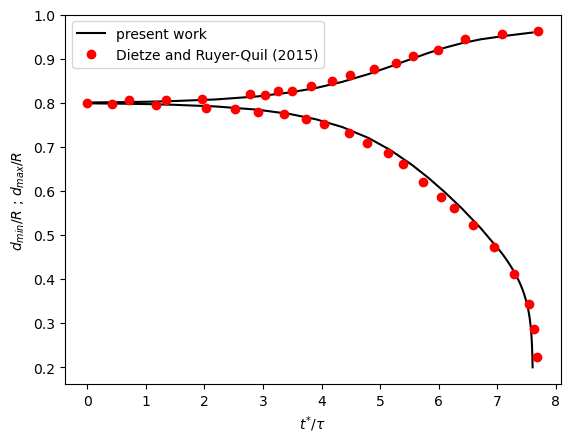

In [30]:
plt.plot(sol.t*((R/u_char)/tau),min_data(sol.y),'k',label = 'present work')
plt.plot(sol.t*((R/u_char)/tau),max_data(sol.y),'k')
plt.plot(t_data_min,d_min_data,'or',label = 'Dietze and Ruyer-Quil (2015)')
plt.plot(t_data_max,d_max_data,'or')
plt.xlabel(r'$t^{*}/\tau$')
plt.ylabel(r'$d_{min}/R$ ; $d_{max}/R$ ')
plt.legend()